# <p style="background-color:#50727B;font-family:Segoe UI;color:#FFFFF;font-size:120%;text-align:center;border-radius:10px 10px;">Modelado y Generación Musical: Una Aproximación Mediante Redes Neuronales y Entradas MIDI</p>


<p style="font-family:Segoe UI;font-size:120%;color:#FFFFF;">Welcome to this Jupyter Notebook, the digital canvas where my two greatest passions converge: music and machine learning. At the heart of this exploration lies a fascination with the intricate dance between technology and melody, an adventure into how ML can transform MIDI notes into captivating symphonies. As we embark on this journey together, we delve into the algorithms and creativity that fuel the future of music generation. Music, my utmost passion, serves as both the inspiration and the destination for this academic endeavor. Join me as we uncover the melodies that lie waiting in the realm of bits and bytes, crafting harmonies guided by the science of artificial intelligence.</p> 

<div class="list-group" id="list-tab" role="tablist">
 <p style="font-family:newtimeroman;color:#97BACB#97BACB;font-size:120%;text-align:center;border-radius:40px 40px;">TABLE OF CONTENTS</p>

    
* [1. INSTALL DEPENDENCIES](#1)
    
* [2. LOADING DATA](#2)
    
* [3. DATA EXPLORATION](#3)  
    
* [4. DATA PREPREPROCESSING](#4)  
    
* [5. MODEL BUILDING](#5) 
      
* [6. EVALUATING MODELS](#6)
    
* [7. CONCLUSION](#7)
    
* [8. END](#8)


# <p style="background-color:#50727B;font-family:Segoe UI;color:#FFFFF;font-size:120%;text-align:center;border-radius:10px 10px;">Install Dependencies</p>

In [36]:
%pip install pretty_midi
%pip install pypianoroll
%pip install datasets
%pip install torch
%pip install matplotlib
%pip install seaborn    
%pip install music21



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# <p style="background-color:#50727B;font-family:Segoe UI;color:#FFFFF;font-size:120%;text-align:center;border-radius:10px 10px;">Importing Libraries</p>

In [37]:
import pretty_midi
import pandas as pd
import numpy as np
import os
import pypianoroll
import matplotlib.pyplot as plt
from datasets import load_dataset
import random
import seaborn as sns
import torch
import music21


# <p style="background-color:#50727B;font-family:Segoe UI;color:#FFFFF;font-size:120%;text-align:center;border-radius:10px 10px;">Data Processing</p>


<p style="font-family:Segoe UI;font-size:120%;color:#FFFFF;">For this project we will be using MIDI files. We have a few MIDI files focusing mainly on Classical Music, like Bach, Mozzart, Chopin and Schubert. On the other hand, we have files of jazz piano music, extracts of songs like Little Girl Blue, Come Rain or Come Sunshine and New Orleans, among others </p> 


<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Here's an expanded explanation of the features we are extractinh from the MIDI files and why they are important for your project:</p> 


<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Note Attributes (Pitch, Start Time, End Time, Velocity): </p> 

<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Pitch indicates the note's frequency, essential for determining the melody and harmony.</p> 


<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Start Time and End Time provide temporal information about when a note is played and for how long, crucial for the rhythm and phrasing.</p> 


<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Velocity reflects the dynamics of each note, adding expressiveness to the music.</p> 

<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Number of Instruments: Understanding the number of instruments in a piece can help the model learn textural and ensemble complexity, which is key to generating more varied and interesting compositions.</p> 


<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Duration of the Piece: The overall length of a piece can influence the model's ability to generate music with coherent structures over different time scales.</p> 

<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Tempo Changes: The number of tempo changes can indicate sections within a piece and help the model learn about pacing and expression.</p> 

<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Key Signatures: Key signatures provide context on the tonality, helping in generating musically coherent pieces that adhere to a tonal center or modulate interestingly.</p> 


<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Time Signatures: Time signatures are fundamental for understanding the metric structure, enabling the model to generate music with consistent or varied rhythmic patterns.</p>

<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Average, Minimum, and Maximum Pitch: These statistics give insights into the melodic range of a piece, informing the model about the pitch content it might generate to stay within a realistic and expressive range.</p>

<p style="font-family:Segoe UI;font-size:100%;color:#FFFFF;">Average Velocity: Indicates the overall dynamics of a piece, guiding the model to generate music with appropriate loudness levels across different sections.</p>

In [38]:
#FUNCTION TO PROCESS ALL MIDI FILES 
def process_midi_files(folder_path):
    file_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.mid') or filename.endswith('.midi'):
            try:
                # Load the MIDI file
                midi_path = os.path.join(folder_path, filename)
                midi_data = pretty_midi.PrettyMIDI(midi_path)
                music21_stream = music21.converter.parse(midi_path)  # Parse the MIDI file with music21
                print(f"Processing {filename}...")
                
                all_notes = []
                pitches = []
                velocities = []
                start_times = []
                durations = []
                pitch_classes = [0] * 12  # 12 pitch classes for chromatic scale
                
                for instrument in midi_data.instruments:
                    for note in instrument.notes:
                        note_repr = f"({note.pitch},{note.start:.2f},{note.end:.2f},{note.velocity})"
                        all_notes.append(note_repr)
                        pitches.append(note.pitch)
                        velocities.append(note.velocity)
                        start_times.append(note.start)
                        durations.append(note.end - note.start)
                        pitch_classes[note.pitch % 12] += 1  # Increment pitch class count
                
                # Extracting key using music21
                key = music21_stream.analyze('key')
                main_key = f"{key.tonic.name} {key.mode}"
                
                # Extract chords using music21
                chords = set()
                for element in music21_stream.recurse().getElementsByClass('Chord'):
                    chords.add('.'.join(str(p.midi) for p in element.pitches))
                chords_str = ', '.join(chords)
                
                notes_str = ' '.join(all_notes)
                
                avg_pitch = np.mean(pitches) if pitches else 0
                min_pitch = np.min(pitches) if pitches else None
                max_pitch = np.max(pitches) if pitches else None
                avg_velocity = np.mean(velocities) if velocities else 0
                avg_duration = np.mean(durations) if durations else 0
                
                # Calculating polyphony (simultaneous note occurrences)
                polyphony = len([d for d in durations if d > 0]) / midi_data.get_end_time() if durations else 0
                
                # Time between consecutive notes
                intervals = np.diff(sorted(start_times))
                avg_interval = np.mean(intervals) if intervals.size > 0 else 0
                
                tempo_changes = len(midi_data.get_tempo_changes()[0])
                key_signatures = len(midi_data.key_signature_changes)
                time_signatures = len(midi_data.time_signature_changes)
                
                duration = midi_data.get_end_time()
                num_instruments = len(midi_data.instruments)
                
                file_data.append({
                    'filename': filename,
                    'num_instruments': num_instruments,
                    'duration': duration,
                    'tempo_changes': tempo_changes,
                    'key_signatures': key_signatures,
                    'time_signatures': time_signatures,
                    'avg_pitch': avg_pitch,
                    'min_pitch': min_pitch,
                    'max_pitch': max_pitch,
                    'avg_velocity': avg_velocity,
                    'avg_duration': avg_duration,
                    'polyphony': polyphony,
                    'avg_interval': avg_interval,
                    'pitch_classes': pitch_classes,  # Pitch class distribution
                    'main_key': main_key,  # Main key of the piece
                    'chords': chords_str,  # Chord progressions
                    'notes': notes_str,  # Note sequences
                })
                print(f"Processed {filename}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")
    return pd.DataFrame(file_data)



In [39]:
#LOCAL FOLDER PATH
folder_path = '/Users/santiago.perez.gutierrez/Documents/ITAM/Tesina/Dataset Final'

#HUGGING FACE DATASET
#dataset = load_dataset('SantiagoPG/classical_music') 

midi_data = process_midi_files(folder_path)

Processing Irememberyousolo.mid...
Processed Irememberyousolo.mid
Processing bach_847.mid...
Processed bach_847.mid
Processing MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID--AUDIO_20_R2_2004_08_Track08_wav.midi...
Processed MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID--AUDIO_20_R2_2004_08_Track08_wav.midi
Processing bach_846.mid...
Processed bach_846.mid
Processing bach_850.mid...
Processed bach_850.mid
Processing Come Rain or Come Shine V1.mid...
Processed Come Rain or Come Shine V1.mid
Processing MIDI-Unprocessed_083_PIANO083_MID--AUDIO-split_07-09-17_Piano-e_2_-06_wav--4.midi...
Processed MIDI-Unprocessed_083_PIANO083_MID--AUDIO-split_07-09-17_Piano-e_2_-06_wav--4.midi
Processing schuim-4.mid...
Processed schuim-4.mid
Processing schuim-3.mid...
Processed schuim-3.mid
Processing mz_332_3.mid...
Processed mz_332_3.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1997 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Processing scn15_4.mid...
Processed scn15_4.mid
Processing MIDI-Unprocessed_Recital17-19_MID--AUDIO_18_R1_2018_wav--3.midi...
Processed MIDI-Unprocessed_Recital17-19_MID--AUDIO_18_R1_2018_wav--3.midi
Processing mz_330_2.mid...
Processed mz_330_2.mid
Processing DeepPurple.mid...
Processed DeepPurple.mid
Processing mz_545_3.mid...
Processed mz_545_3.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Gl\xfcckes genug'>; getting generic Instrument
  warnings.warn(


Processing scn15_5.mid...
Processed scn15_5.mid
Processing merryxmas.mid...
Processed merryxmas.mid
Processing Autumn In NY.mid...
Processed Autumn In NY.mid
Processing scn15_2.mid...
Processed scn15_2.mid
Processing scn15_3.mid...
Processed scn15_3.mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2000 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


Processing bor_ps1.mid...
Processed bor_ps1.mid
Processing MIDI-Unprocessed_075_PIANO075_MID--AUDIO-split_07-08-17_Piano-e_2-06_wav--3.midi...
Processed MIDI-Unprocessed_075_PIANO075_MID--AUDIO-split_07-08-17_Piano-e_2-06_wav--3.midi
Processing mz_333_1.mid...
Processed mz_333_1.mid
Processing NewOrleans.mid...
Processed NewOrleans.mid
Processing muss_8.mid...
Processed muss_8.mid
Processing schu_143_1.mid...
Processed schu_143_1.mid
Processing mz_331_1.mid...
Processed mz_331_1.mid
Processing bor_ps2.mid...
Processed bor_ps2.mid
Processing debussy_cc_4.mid...
Processed debussy_cc_4.mid
Processing bor_ps3.mid...
Processed bor_ps3.mid
Processing chpn-p17.mid...
Processed chpn-p17.mid
Processing Little Girl Blue.mid...
Processed Little Girl Blue.mid
Processing MIDI-Unprocessed_Schubert4-6_MID--AUDIO_08_R2_2018_wav.midi...
Processed MIDI-Unprocessed_Schubert4-6_MID--AUDIO_08_R2_2018_wav.midi
Processing MIDI-Unprocessed_Recital17-19_MID--AUDIO_17_R1_2018_wav--3.midi...
Processed MIDI-Unpro

In [40]:
midi_data.head()

,filename,num_instruments,duration,tempo_changes,key_signatures,time_signatures,avg_pitch,min_pitch,max_pitch,avg_velocity,avg_duration,polyphony,avg_interval,pitch_classes,main_key,chords,notes
0,Irememberyousolo.mid,1,695.791250,1,1,1,65.399812,24,108,46.890975,0.243722,9.188101,0.108840,"[841, 363, 708, 287, 750, 904, 254, 556, 208, ...",F major,"57.62.72.77, 67.63.81, 45.74, 46.40, 88.76.81....","(79,0.04,0.14,27) (81,0.03,0.14,36) (48,0.04,0..."
1,bach_847.mid,5,189.754186,445,1,1,60.414092,36,84,69.015176,0.240037,9.723106,0.099998,"[300, 3, 243, 253, 53, 259, 40, 264, 143, 75, ...",C minor,"51.55, 67.58, 57.54, 56.55, 55.60, 53.55, 68.6...","(72,0.00,0.14,96) (63,0.12,0.25,80) (62,0.23,0..."
2,MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID...,1,260.390625,1,0,1,67.279564,30,102,70.726400,0.084478,14.808521,0.067118,"[288, 574, 359, 93, 384, 256, 464, 138, 494, 3...",F# minor,"53.47, 53.65.37.61, 81.89.77.84.56, 67.71, 72....","(78,1.02,1.07,77) (66,1.07,1.10,50) (73,1.07,1..."
3,bach_846.mid,6,296.669528,349,1,1,63.114486,36,84,55.661215,0.521587,4.328048,0.172277,"[207, 11, 184, 6, 166, 131, 41, 217, 16, 163, ...",C major,"36.48, 77.79, 72.74, 50.48, 67.69, 72.70, 64.6...","(67,0.41,0.61,56) (72,0.61,0.81,60) (76,0.81,0..."
4,bach_850.mid,6,172.971734,288,1,1,64.283433,38,83,59.071191,0.311023,8.689281,0.112028,"[40, 144, 226, 14, 208, 24, 202, 184, 41, 214,...",D major,"42.43, 76.78.79, 74.76.78, 76.74.73, 52.50, 74...","(74,0.11,0.23,57) (76,0.21,0.33,57) (78,0.32,0..."


# <p style="background-color:#50727B;font-family:Segoe UI;color:#FFFFF;font-size:120%;text-align:center;border-radius:10px 10px;">Data Exploration</p>


In [41]:
midi_data.describe()

,num_instruments,duration,tempo_changes,key_signatures,time_signatures,avg_pitch,min_pitch,max_pitch,avg_velocity,avg_duration,polyphony,avg_interval
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,1.941176,383.905185,607.676471,1.382353,1.647059,63.941823,30.294118,92.970588,52.576268,0.356616,8.666687,0.133898
std,1.277810,343.876056,868.790511,1.456744,2.816427,2.810635,6.201317,9.216209,9.610997,0.205206,3.263052,0.068063
min,1.000000,31.358879,1.000000,0.000000,1.000000,57.168397,14.000000,79.000000,34.263727,0.084478,2.522720,0.060930
25%,1.000000,161.089667,1.000000,1.000000,1.000000,61.660296,25.250000,84.500000,46.604561,0.210941,6.691028,0.090520
50%,2.000000,307.789167,317.000000,1.000000,1.000000,64.012590,29.500000,92.000000,53.111488,0.310149,9.134081,0.108682
75%,2.000000,430.485085,620.000000,1.000000,1.000000,66.450561,35.750000,101.000000,59.206435,0.466412,10.789454,0.146561
max,6.000000,1749.039062,3190.000000,7.000000,17.000000,68.928726,45.000000,108.000000,70.726400,1.049082,15.679379,0.392356


In [42]:
midi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         34 non-null     object 
 1   num_instruments  34 non-null     int64  
 2   duration         34 non-null     float64
 3   tempo_changes    34 non-null     int64  
 4   key_signatures   34 non-null     int64  
 5   time_signatures  34 non-null     int64  
 6   avg_pitch        34 non-null     float64
 7   min_pitch        34 non-null     int64  
 8   max_pitch        34 non-null     int64  
 9   avg_velocity     34 non-null     float64
 10  avg_duration     34 non-null     float64
 11  polyphony        34 non-null     float64
 12  avg_interval     34 non-null     float64
 13  pitch_classes    34 non-null     object 
 14  main_key         34 non-null     object 
 15  chords           34 non-null     object 
 16  notes            34 non-null     object 
dtypes: float64(6), int

### Number of Instruments

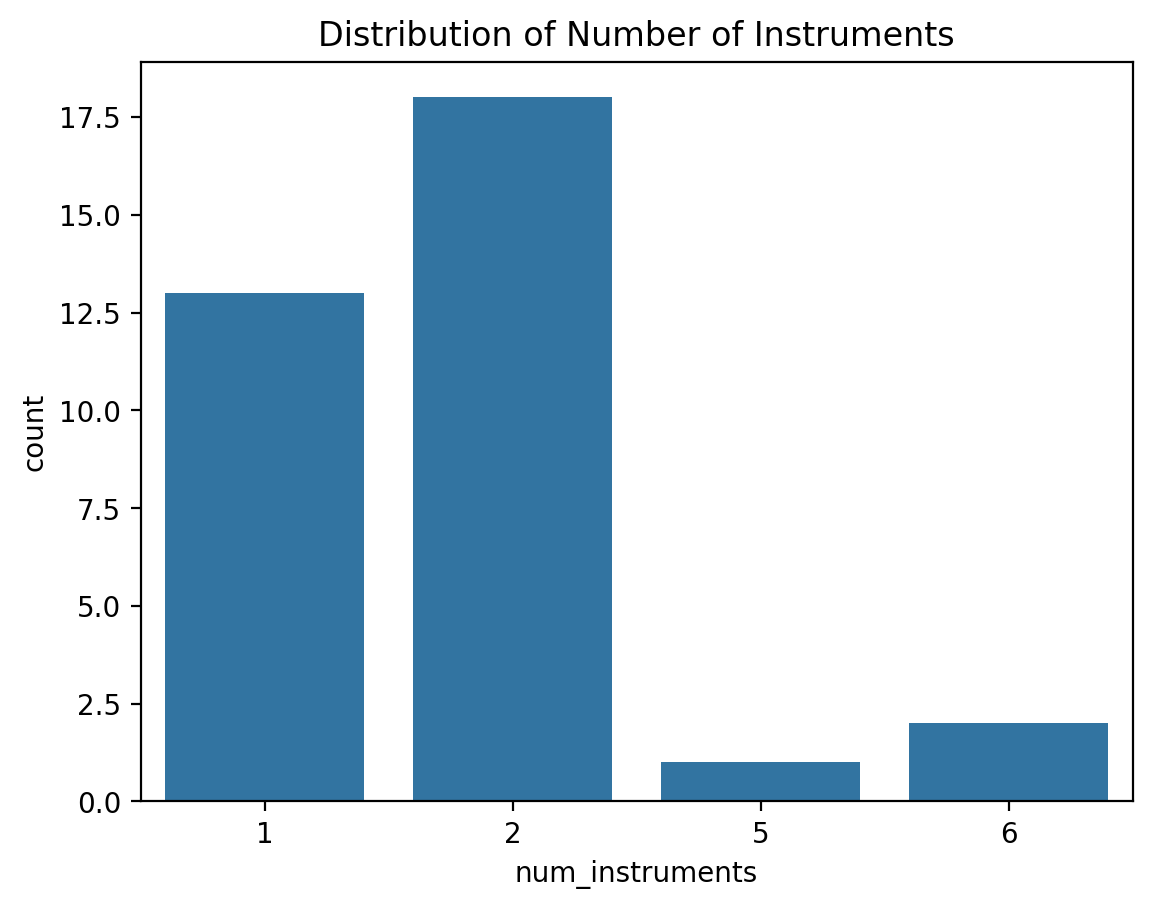

In [43]:
# Distribution of the number of instruments
sns.countplot(x='num_instruments', data=midi_data)
plt.title('Distribution of Number of Instruments')
plt.show()

Instrument Number Analysis:

As we see in the 

### Duration of the MIDI files

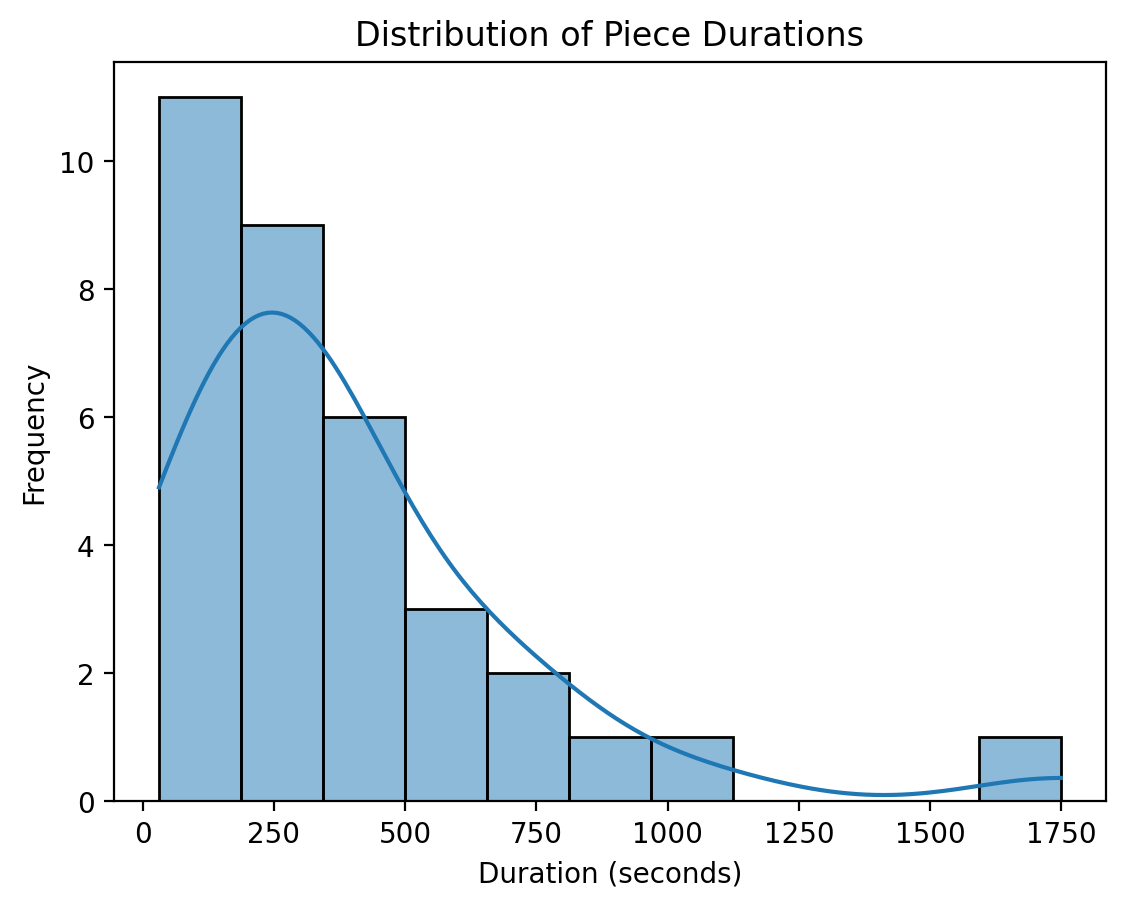

In [46]:
# Histogram of durations
sns.histplot(midi_data['duration'], kde=True)
plt.title('Distribution of Piece Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

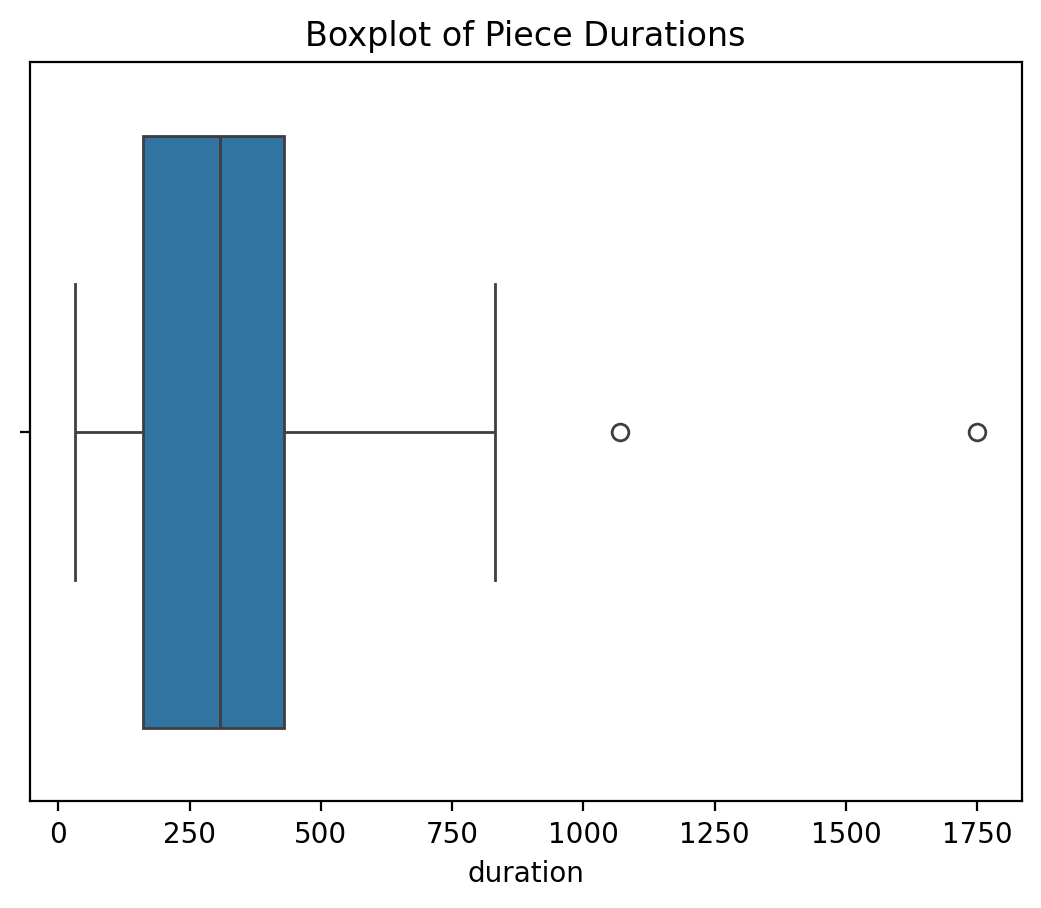

In [47]:
# Boxplot for durations to identify outliers
sns.boxplot(x='duration', data=midi_data)
plt.title('Boxplot of Piece Durations')
plt.show()

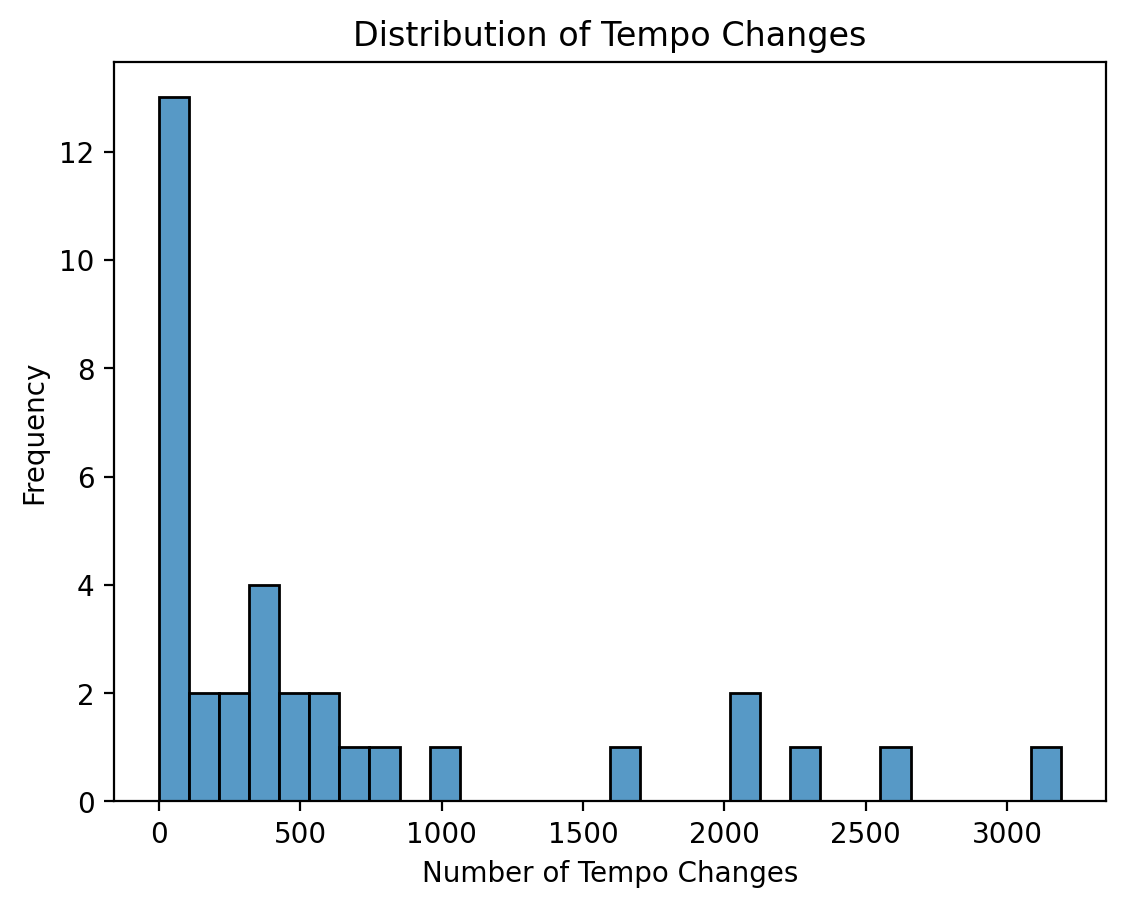

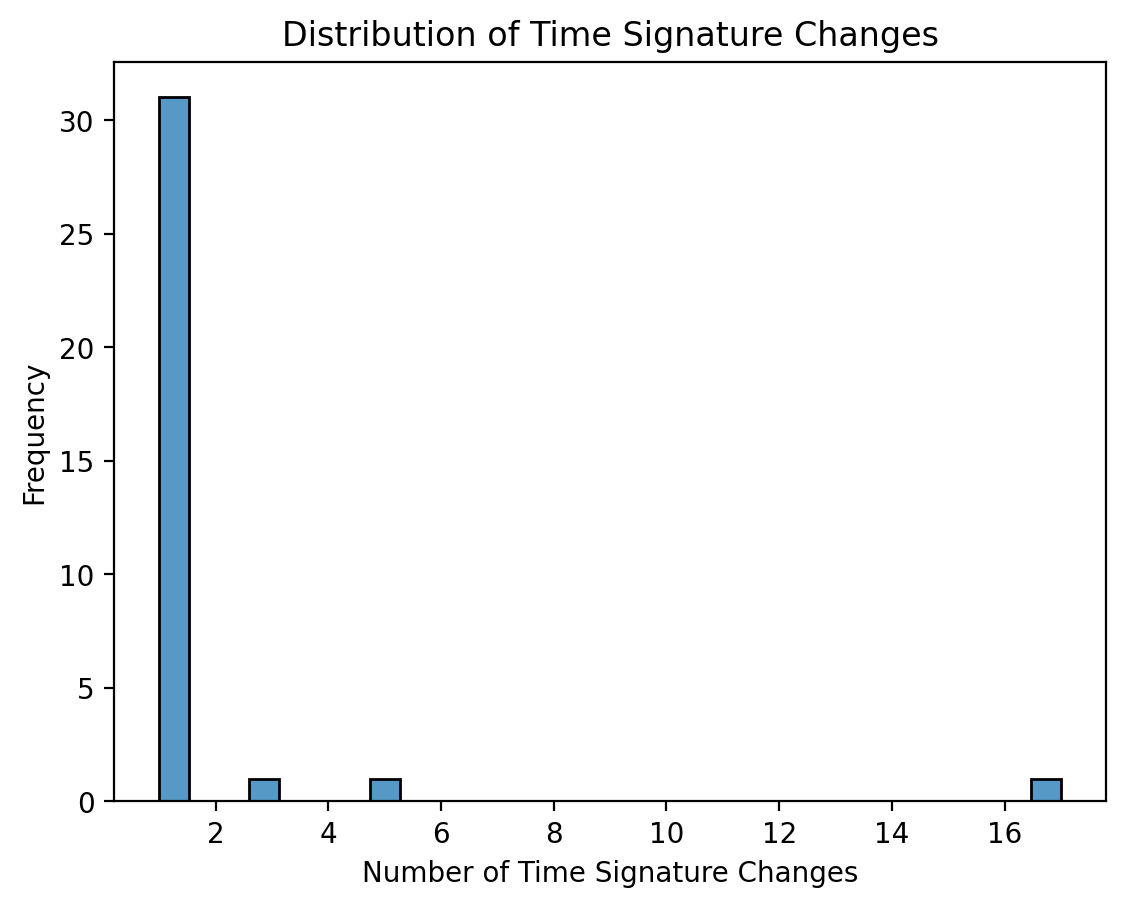

In [48]:
# Histogram of tempo changes
sns.histplot(midi_data['tempo_changes'], bins=30)
plt.title('Distribution of Tempo Changes')
plt.xlabel('Number of Tempo Changes')
plt.ylabel('Frequency')
plt.show()

# Histogram of time signature changes
sns.histplot(midi_data['time_signatures'], bins=30)
plt.title('Distribution of Time Signature Changes')
plt.xlabel('Number of Time Signature Changes')
plt.ylabel('Frequency')
plt.show()

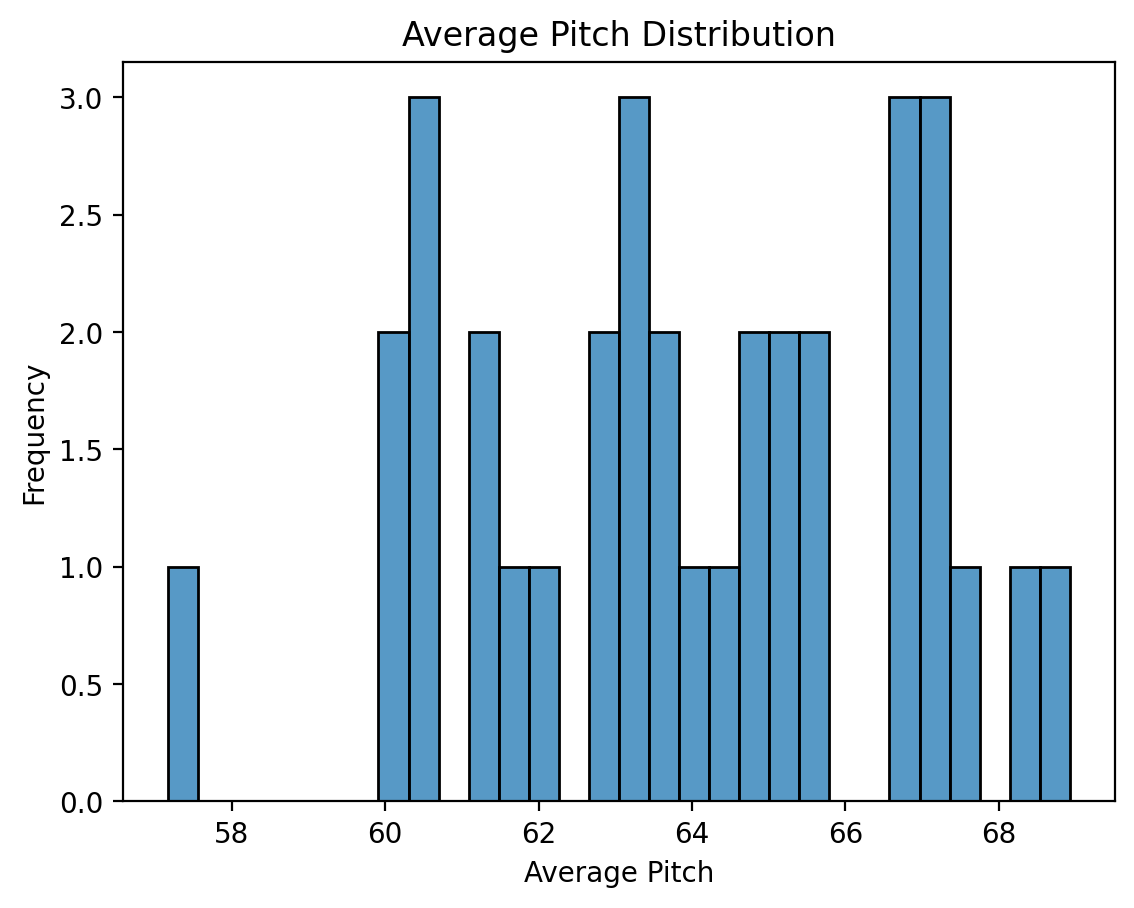

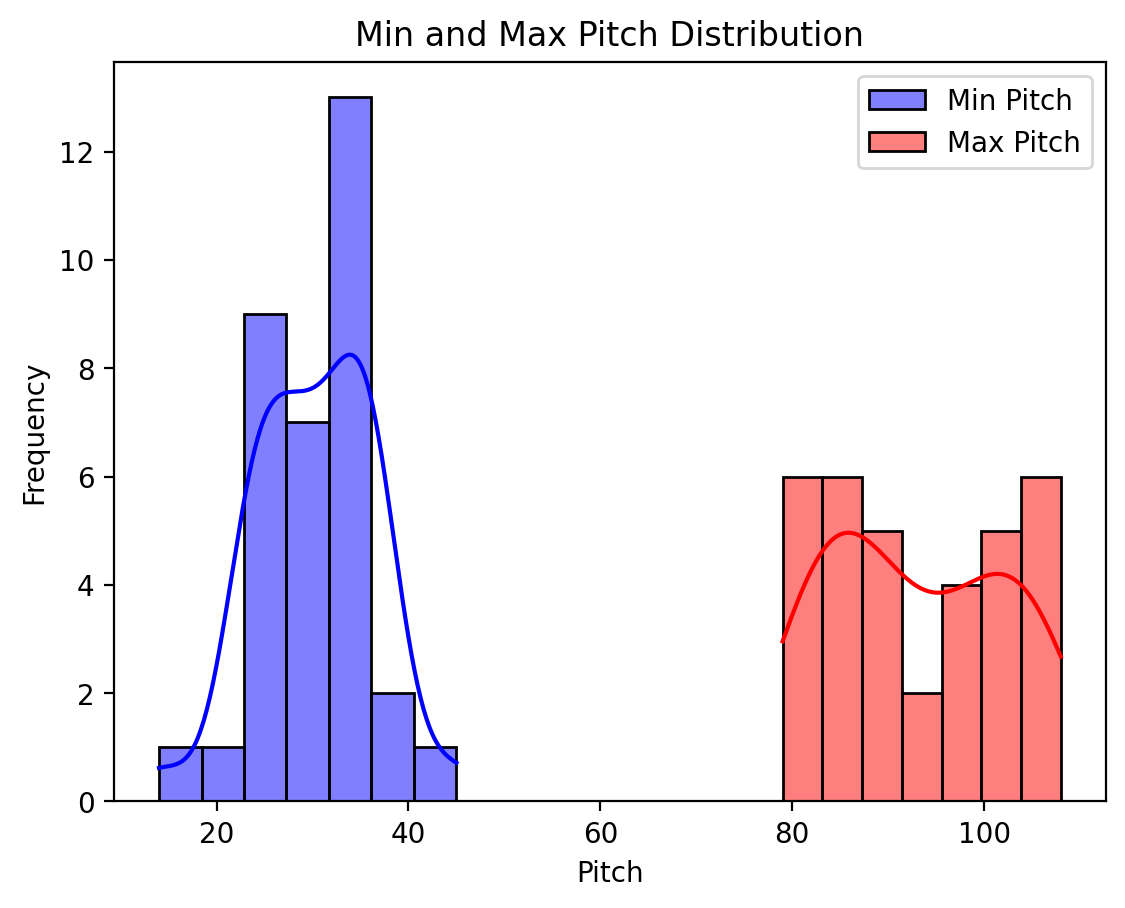

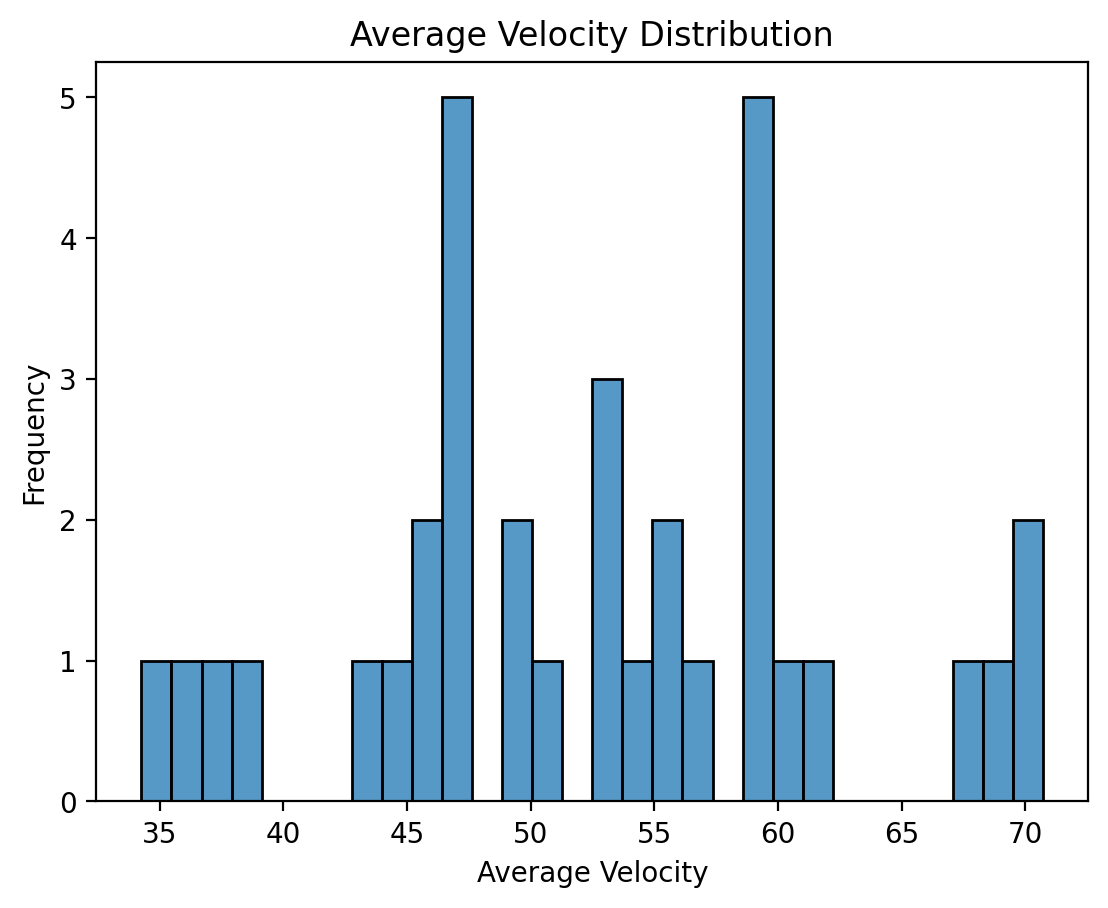

In [49]:
# Average Pitch Distribution
sns.histplot(midi_data['avg_pitch'], bins=30)
plt.title('Average Pitch Distribution')
plt.xlabel('Average Pitch')
plt.ylabel('Frequency')
plt.show()

# Min and Max Pitch Distribution
sns.histplot(midi_data['min_pitch'], color='blue', label='Min Pitch', kde=True)
sns.histplot(midi_data['max_pitch'], color='red', label='Max Pitch', kde=True)
plt.legend()
plt.title('Min and Max Pitch Distribution')
plt.xlabel('Pitch')
plt.ylabel('Frequency')
plt.show()

# Average Velocity Distribution
sns.histplot(midi_data['avg_velocity'], bins=30)
plt.title('Average Velocity Distribution')
plt.xlabel('Average Velocity')
plt.ylabel('Frequency')
plt.show()


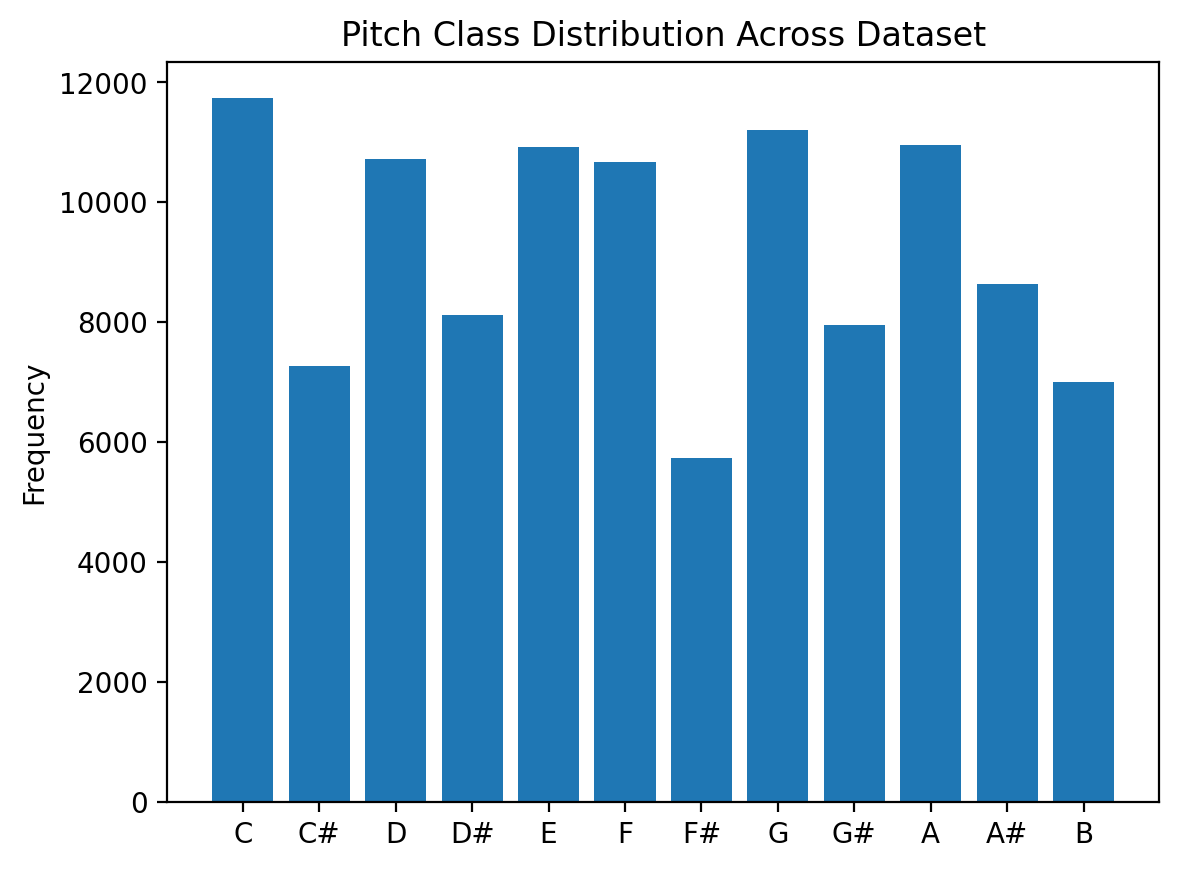

In [50]:
# Aggregate pitch class distributions from all files
total_pitch_classes = [0] * 12
for pc in midi_data['pitch_classes']:
    for i in range(12):
        total_pitch_classes[i] += pc[i]

# Plotting
fig, ax = plt.subplots()
ax.bar(range(12), total_pitch_classes)
ax.set_xticks(range(12))
ax.set_xticklabels(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
ax.set_title('Pitch Class Distribution Across Dataset')
ax.set_ylabel('Frequency')
plt.show()


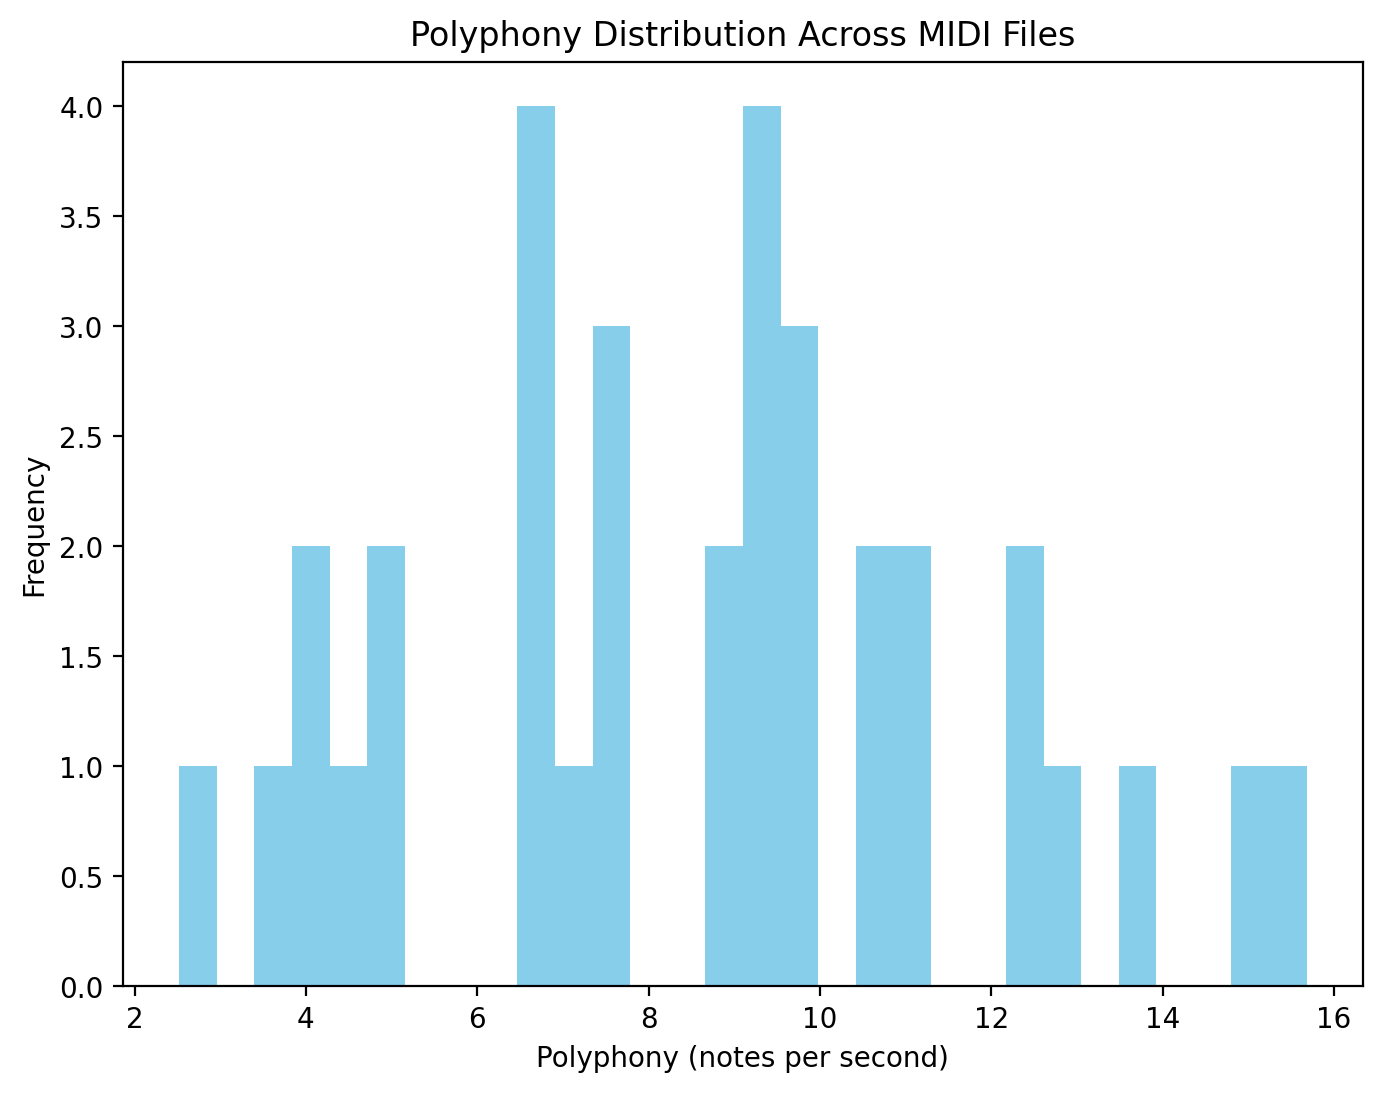

In [52]:
# Plotting the distribution of polyphony
plt.figure(figsize=(8, 6))
plt.hist(midi_data['polyphony'], bins=30, color='skyblue')
plt.title('Polyphony Distribution Across MIDI Files')
plt.xlabel('Polyphony (notes per second)')
plt.ylabel('Frequency')
plt.show()


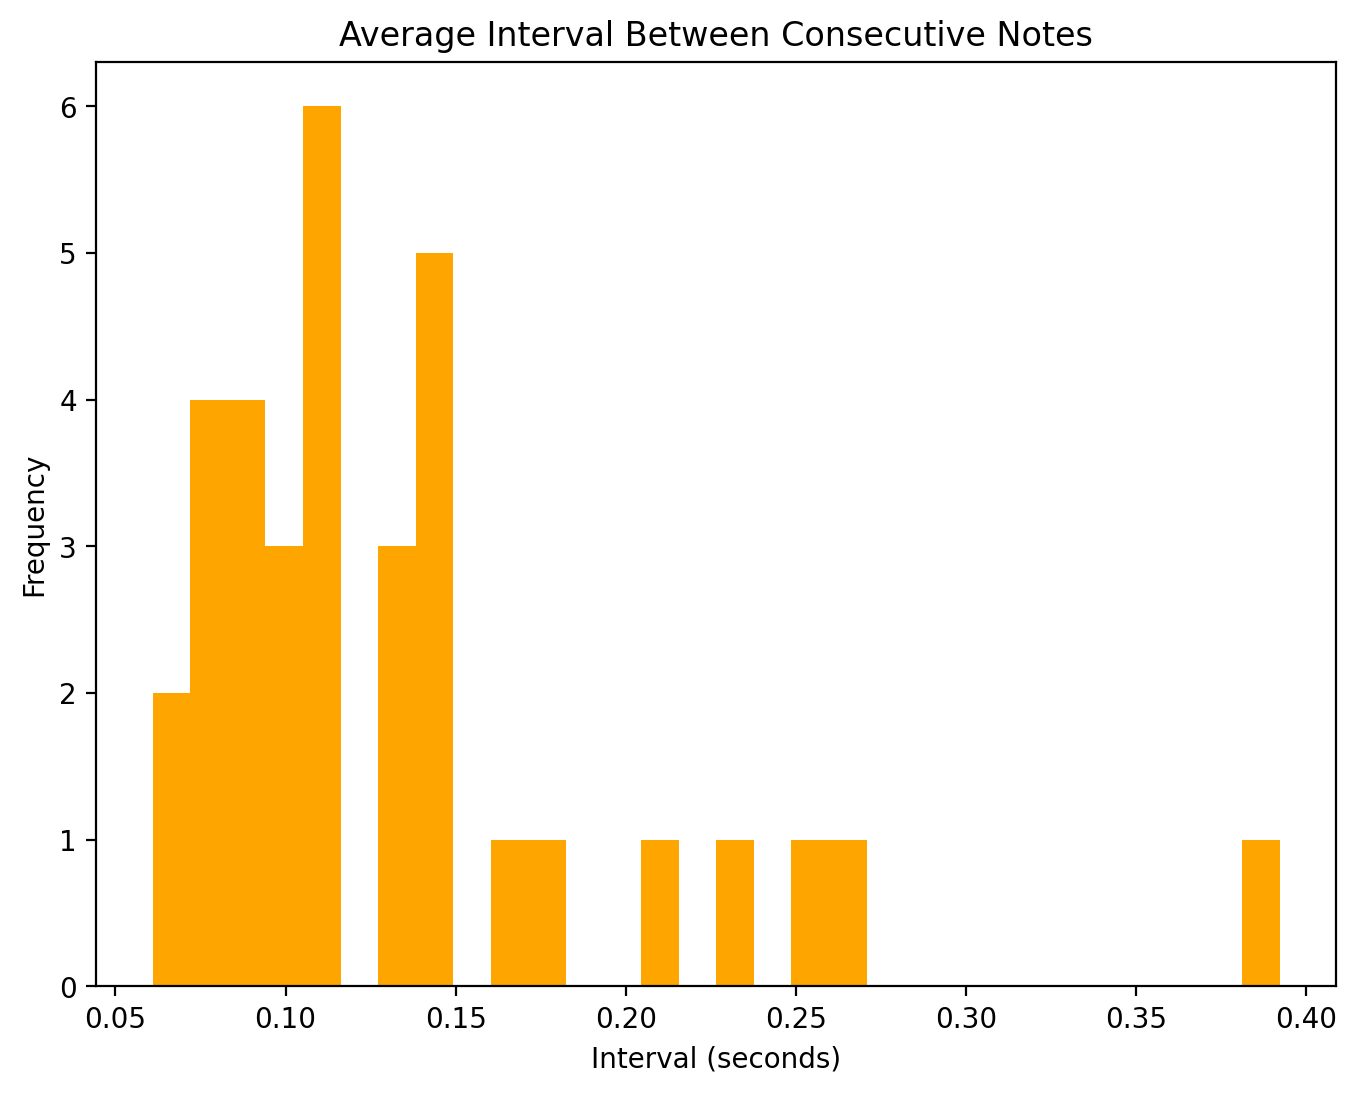

In [53]:
# Plotting the average interval between consecutive notes
plt.figure(figsize=(8, 6))
plt.hist(midi_data['avg_interval'], bins=30, color='orange')
plt.title('Average Interval Between Consecutive Notes')
plt.xlabel('Interval (seconds)')
plt.ylabel('Frequency')
plt.show()


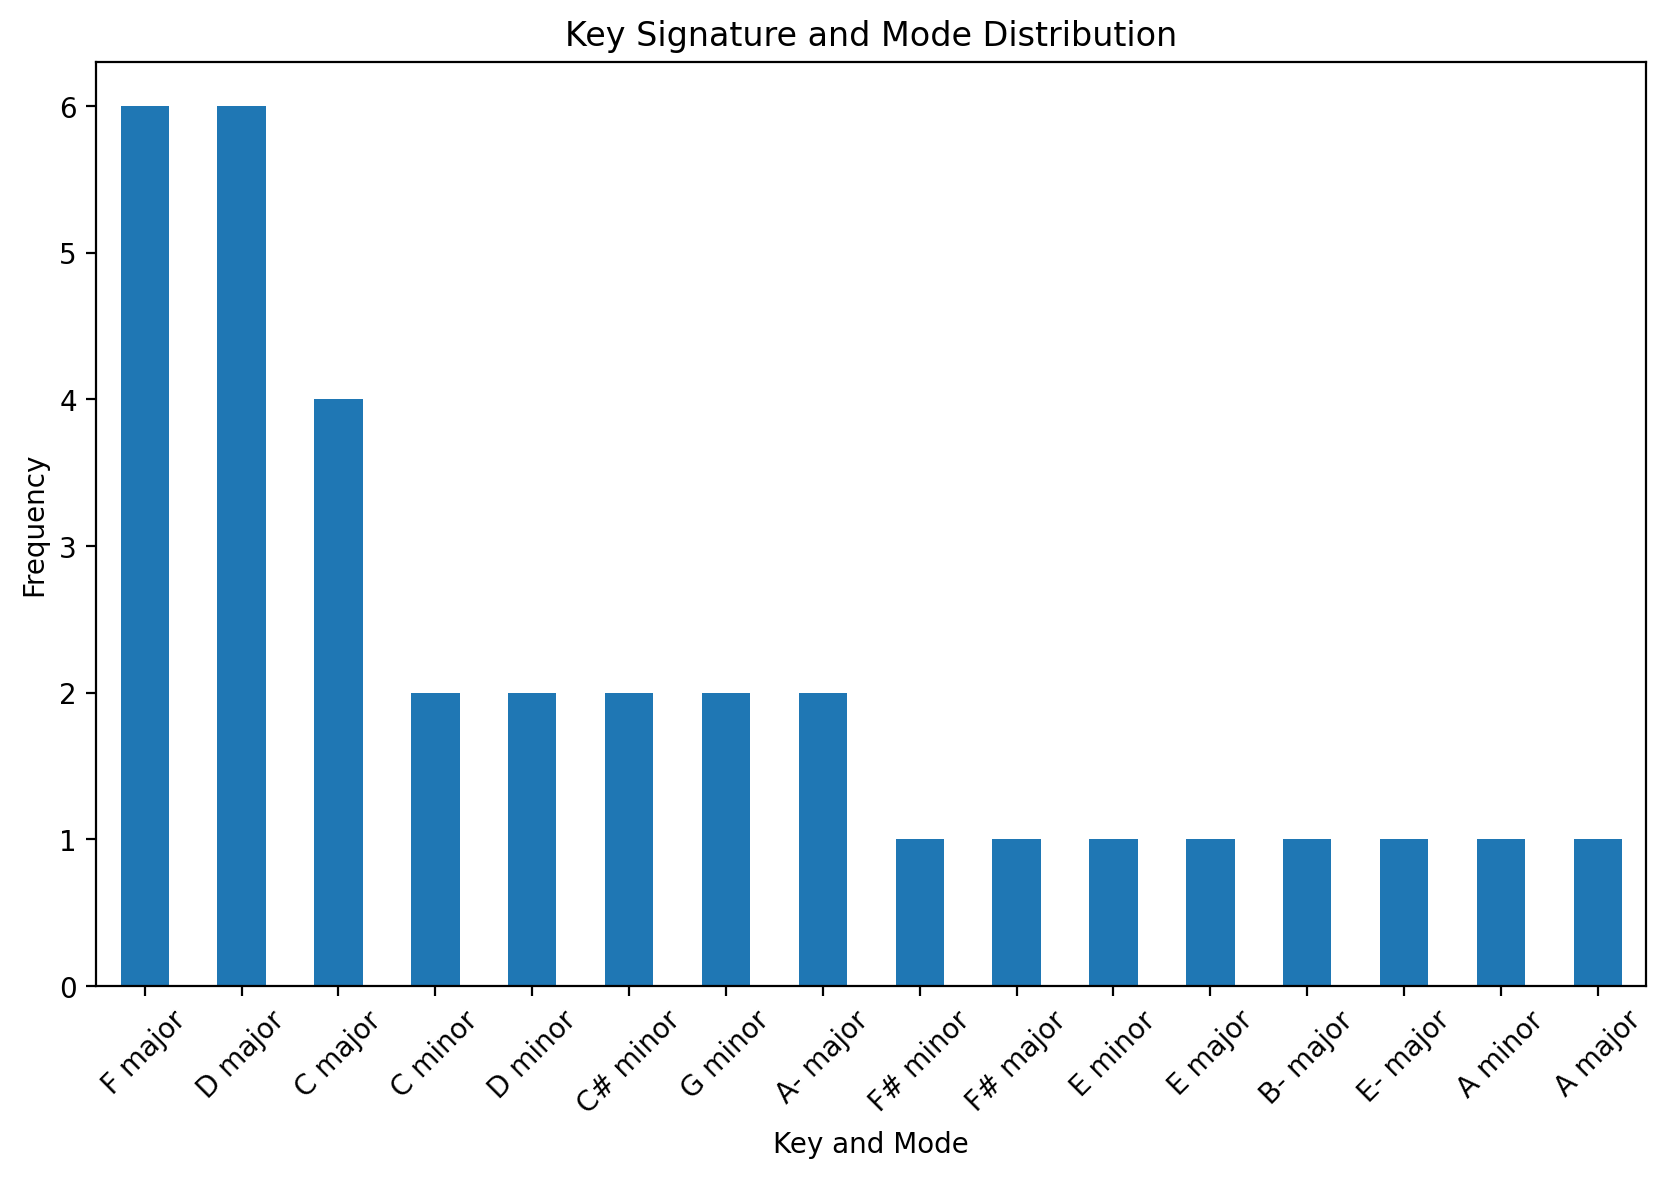

In [54]:
# Extracting key signatures and modes
keys = midi_data['main_key'].value_counts()

# Plotting
keys.plot(kind='bar', figsize=(10, 6))
plt.title('Key Signature and Mode Distribution')
plt.xlabel('Key and Mode')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [56]:
# Extracting key signatures and modes
keys = midi_data['main_key'].value_counts()

print(keys)
print(sum(keys))


main_key
F major     6
D major     6
C major     4
C minor     2
D minor     2
C# minor    2
G minor     2
A- major    2
F# minor    1
F# major    1
E minor     1
E major     1
B- major    1
E- major    1
A minor     1
A major     1
Name: count, dtype: int64
34


In [57]:
from collections import Counter

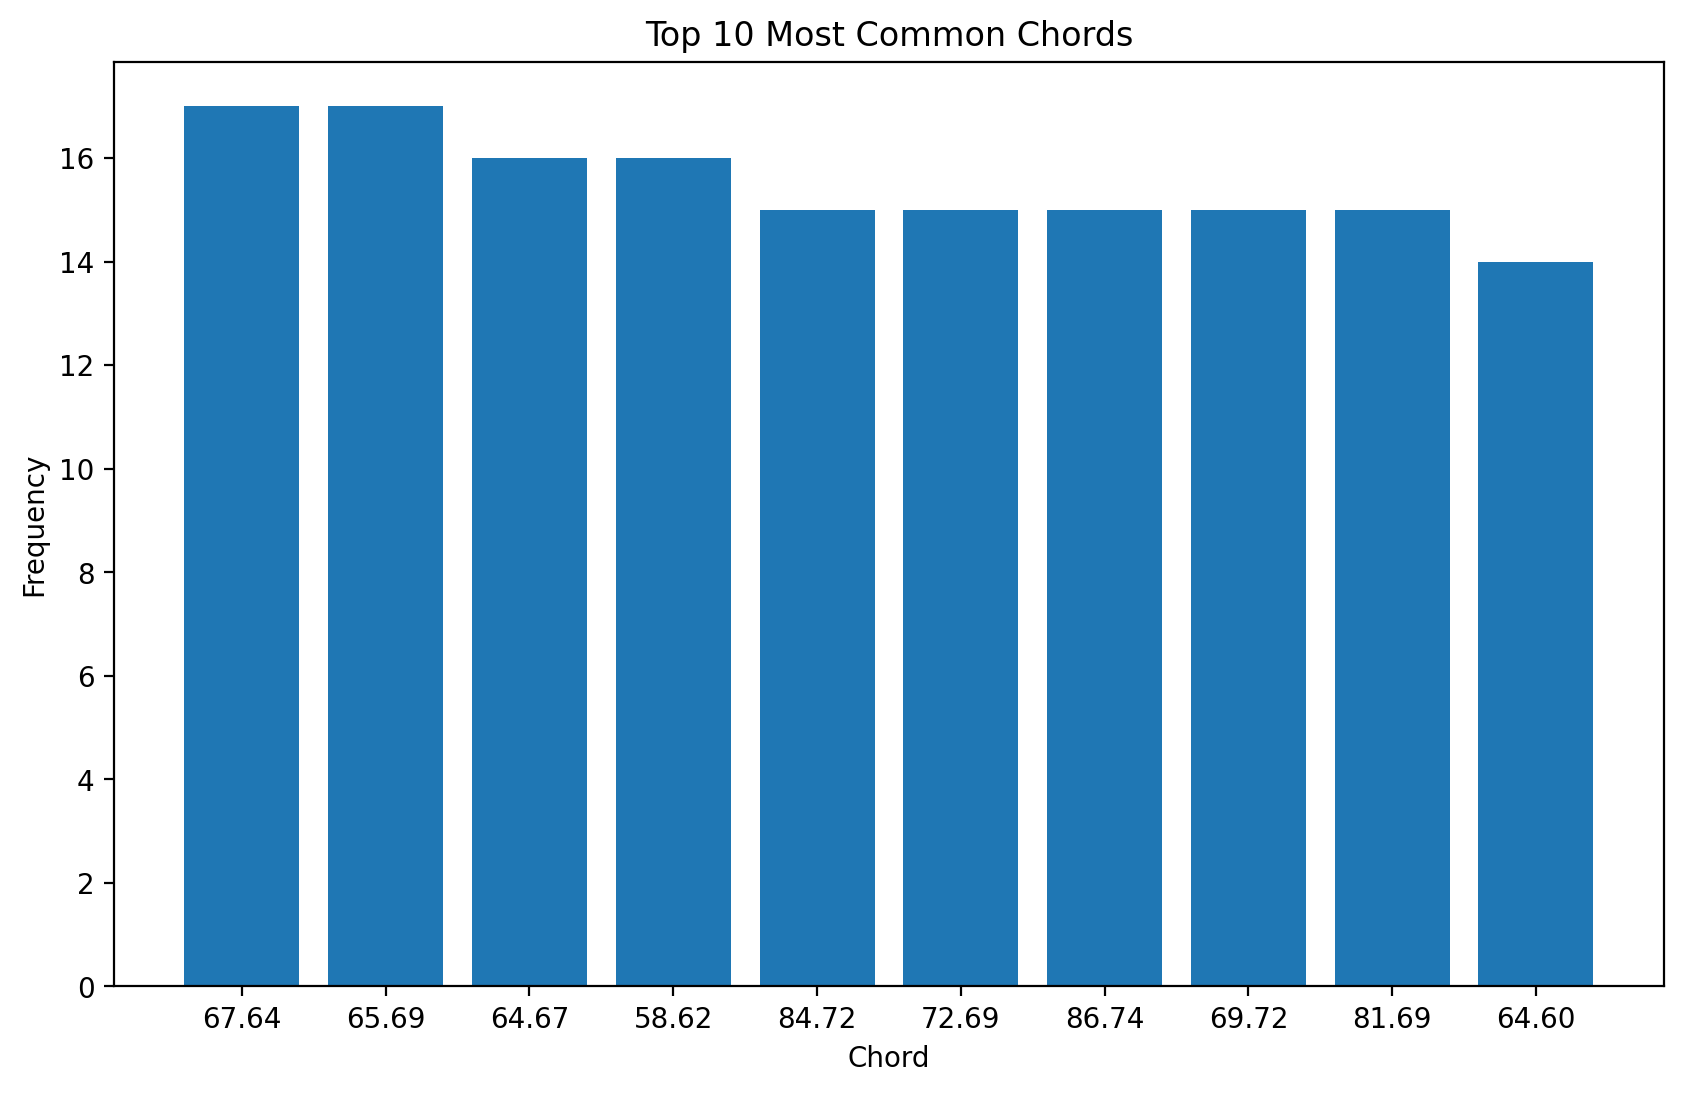

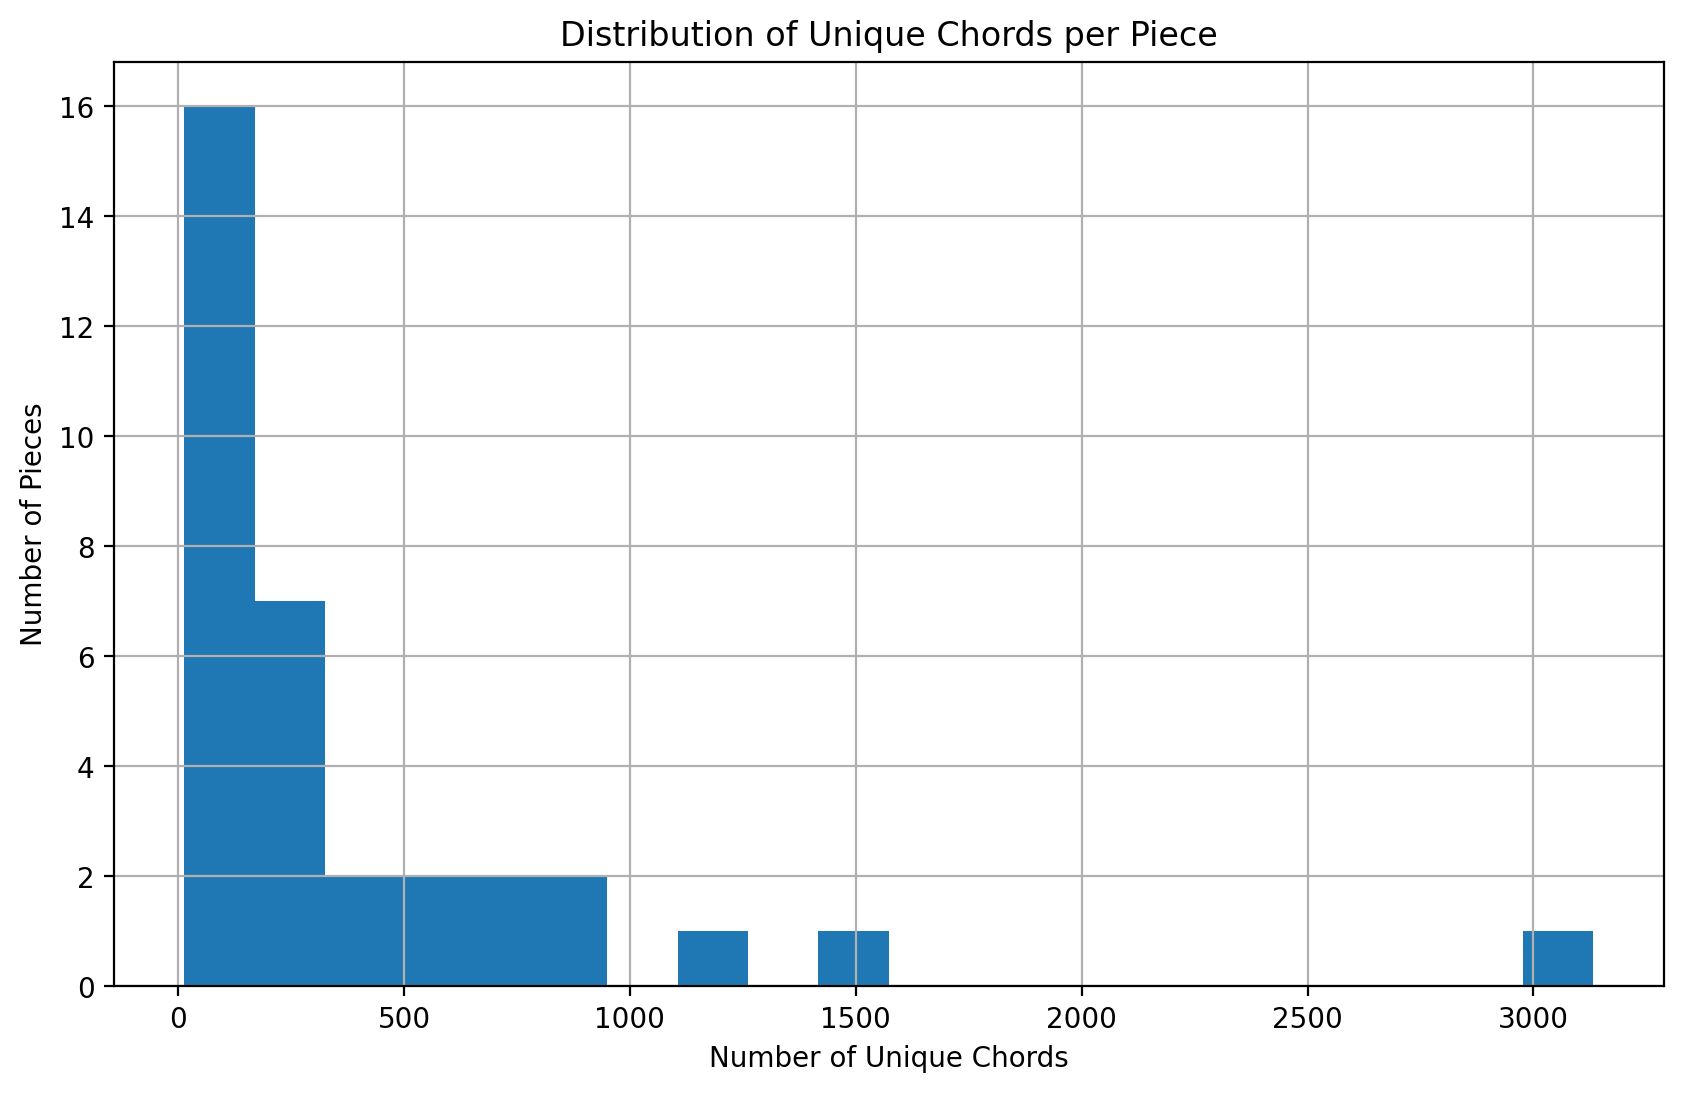

In [58]:

# Assuming `chords` column contains strings of unique chords separated by commas
midi_data['chord_list'] = midi_data['chords'].apply(lambda x: x.split(', '))

# Chord Frequency Distribution
all_chords = [chord for sublist in midi_data['chord_list'] for chord in sublist]
chord_counts = Counter(all_chords)
most_common_chords = chord_counts.most_common(10)  # Adjust as needed

# Plotting the most common chords
plt.figure(figsize=(10, 6))
plt.bar([chord[0] for chord in most_common_chords], [chord[1] for chord in most_common_chords])
plt.xlabel('Chord')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Chords')
plt.show()

# Chord Diversity per Piece
midi_data['unique_chords_count'] = midi_data['chord_list'].apply(len)
plt.figure(figsize=(10, 6))
midi_data['unique_chords_count'].hist(bins=20)
plt.xlabel('Number of Unique Chords')
plt.ylabel('Number of Pieces')
plt.title('Distribution of Unique Chords per Piece')
plt.show()